In [1]:
! pip install pyreadstat pyarrow matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 8.2 MB/s eta 0:00:0000:0100:01
  Using cached pyparsing-3.1.2-py3-none-any.whl (103 kB)
  Using cached importlib_resources-6.4.0-py3-none-any.whl (38 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.0/245.0 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.2 MB/s eta 0:00:0000:0100:01
  Using cached kiwisolver-1.4.5-cp39-cp39-macosx_11_0_arm64.whl (66 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 14.0 MB/s eta 0:00:0000:0100:01
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
import pandas as pd

Taiwan_QQQ = pd.read_feather("Cleaned.feather")

# 切割資料集為訓練集和測試集
from sklearn.model_selection import train_test_split
X = Taiwan_QQQ.drop(['Math_level'], axis=1)
y = Taiwan_QQQ['Math_level']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

mi = mutual_info_classif(X_train, y_train)
mi_scores = pd.Series(mi, index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)  # 降序排序
print(mi_scores[:100])

JOYREAD       0.085828
ST225Q06HA    0.082038
ST165Q04IA    0.077540
MMINS         0.073772
METASPAM      0.073268
                ...   
BELONG        0.025428
ST215Q01HA    0.025282
IC011Q01TA    0.024925
INFOJOB2      0.024855
TEACHSUP      0.024758
Length: 100, dtype: float64


In [5]:
selected_column = mi_scores[:100].keys()
X_train = X_train[selected_column]
X_test = X_test[selected_column]

X_train.head()

,JOYREAD,ST225Q06HA,ST165Q04IA,MMINS,METASPAM,METASUM,UNDREM,ISCEDD,INFOCAR,AWACOM,...,SOIAICT,ST218Q03HA,ST059Q03TA,ATTLNACT,ST062Q02TA,BELONG,ST215Q01HA,IC011Q01TA,INFOJOB2,TEACHSUP
571621,-0.6996,0.0,3.0,200.0,-1.41,-0.18,1.15,3.0,2.2523,-1.3933,...,-2.1763,2.0,2.0,-1.1507,3.0,-0.3184,2.0,1.0,1.4601,-1.4974
568626,0.6380,1.0,4.0,300.0,0.42,1.36,0.80,1.0,-0.6558,0.1833,...,-0.6261,3.0,7.0,-0.6583,1.0,0.3018,2.0,4.0,0.8028,-0.6783
572855,-2.7114,1.0,4.0,300.0,0.42,0.21,-0.94,1.0,-1.0276,-0.1577,...,-0.2162,3.0,4.0,-1.1507,1.0,-0.5665,3.0,1.0,-1.4728,1.3140
573892,-0.9615,0.0,1.0,250.0,-1.41,-1.72,-0.60,1.0,-1.0276,-1.4601,...,-1.4287,3.0,5.0,-1.6055,1.0,0.0928,5.0,1.0,-1.4728,0.0610
573109,1.4712,1.0,4.0,220.0,-0.04,-0.57,0.45,3.0,-1.9096,-2.7948,...,-0.3139,1.0,5.0,1.0844,1.0,0.1538,1.0,3.0,-1.4728,-2.7106


In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# 設定參數網格
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.1, 1, 10]
}

# 創建 GridSearchCV 物件
svm_grid_search = GridSearchCV(SVC(), svm_param_grid, cv=5, verbose=4, n_jobs=-1)

# 執行網格搜索
svm_grid_search.fit(X_train, y_train)

# 访问 cv_results_
cv_results = svm_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(cv_results['params'])):
    print("Params:", cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j+1} score:", cv_results[f'split{j}_test_score'][i])

# 最佳參數和模型
print("Best parameters:", svm_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(svm_grid_search.best_score_))

# 使用最佳參數的模型對測試集進行預測
best_model = svm_grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(test_score))

Fitting 5 folds for each of 27 candidates, totalling 135 fits


KeyboardInterrupt: 

In [8]:
from sklearn.ensemble import RandomForestClassifier

# 設定參數網格
rf_param_grid = {
    'n_estimators': [100, 200, 300],  # 決策樹的數量
    'max_depth': [None, 10, 20, 30],  # 最大深度
    'min_samples_split': [2, 5, 10],  # 每個節點至少包含的數據量，才能繼續分割
    'min_samples_leaf': [1, 2, 4]    # 每個葉子最少的樣本數
}

# 創建 GridSearchCV 物件
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, verbose=2, n_jobs=-1)

# 執行網格搜索
rf_grid_search.fit(X_train, y_train)

# 访问 cv_results_
cv_results = rf_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(cv_results['params'])):
    print("Params:", cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j+1} score:", cv_results[f'split{j}_test_score'][i])

# 最佳參數和模型
print("Best parameters:", rf_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(rf_grid_search.best_score_))

# 使用最佳參數的模型對測試集進行預測
rf_best_model = rf_grid_search.best_estimator_
rf_test_score = rf_best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(rf_test_score))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Fold 1 score: 0.7868852459016393
Fold 2 score: 0.7748058671268335
Fold 3 score: 0.7834339948231234
Fold 4 score: 0.7627264883520276
Fold 5 score: 0.7892918825561313
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Fold 1 score: 0.7998274374460742
Fold 2 score: 0.7799827437446074
Fold 3 score: 0.7851596203623814
Fold 4 score: 0.7748058671268335
Fold 5 score: 0.7892918825561313
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Fold 1 score: 0.8041415012942191
Fold 2 score: 0.7825711820534944
Fold 3 score: 0.7886108714408974
Fold 4 score: 0.7817083692838654
Fold 5 score: 0.7953367875647669
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Fold 1 score: 0.8015530629853321
Fold 2 score: 0.778257118

In [9]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
# 设置参数网格
xg_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 2, 3]
}


# 创建 GridSearchCV 对象
xg_grid_search = GridSearchCV(xgb_model, xg_param_grid, cv=5, verbose=4, n_jobs=-1)

# 执行网格搜索
xg_grid_search.fit(X_train, y_train)

# 访问 cv_results_
cv_results = xg_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(cv_results['params'])):
    print("Params:", cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j+1} score:", cv_results[f'split{j}_test_score'][i])

# 最佳参数和模型
print("Best parameters:", xg_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(xg_grid_search.best_score_))

# 使用最佳参数的模型对测试集进行预测
xgb_best_model = xg_grid_search.best_estimator_
xgb_test_score = xgb_best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(xgb_test_score))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50}
Fold 1 score: 0.730802415875755
Fold 2 score: 0.7497842968075927
Fold 3 score: 0.7558239861949957
Fold 4 score: 0.7351164797238999
Fold 5 score: 0.7556131260794473
Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
Fold 1 score: 0.7402933563416738
Fold 2 score: 0.7592752372735116
Fold 3 score: 0.7601380500431406
Fold 4 score: 0.7489214840379638
Fold 5 score: 0.7677029360967185
Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}
Fold 1 score: 0.7661777394305436
Fold 2 score: 0.7687661777394306
Fold 3 score: 0.7756686798964625
Fold 4 score: 0.7704918032786885
Fold 5 score: 0.7772020725388601
Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 50}
Fold 1 score: 0.730802415875755
Fold 2 score: 0.7497842968075927
Fold 3 score:

In [10]:
from sklearn.linear_model import LogisticRegression

# 设置参数网格
lg_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty':  ['l1', 'l2']
}

# 创建 GridSearchCV 对象
lg_grid_search = GridSearchCV(LogisticRegression(solver='saga'), lg_param_grid, cv=5, verbose=2, n_jobs=-1)

# 执行网格搜索
lg_grid_search.fit(X_train, y_train)

# 访问 cv_results_
cv_results = lg_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(cv_results['params'])):
    print("Params:", cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j+1} score:", cv_results[f'split{j}_test_score'][i])

# 最佳参数和模型
print("Best parameters:", lg_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(lg_grid_search.best_score_))

# 使用最佳参数的模型对测试集进行预测
lg_best_model = lg_grid_search.best_estimator_
lg_test_score = lg_best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(lg_test_score))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/ponywen/Documents/projects/DataSciFinal/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/projects/DataSciFinal/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/projects/DataSciFinal/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/projects/DataSciFinal/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/projects/DataSciFinal/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The ma

Params: {'C': 0.01, 'penalty': 'l1'}
Fold 1 score: 0.7109577221742882
Fold 2 score: 0.6652286453839517
Fold 3 score: 0.6937014667817084
Fold 4 score: 0.6531492666091459
Fold 5 score: 0.6848013816925734
Params: {'C': 0.01, 'penalty': 'l2'}
Fold 1 score: 0.7169974115616912
Fold 2 score: 0.6755823986194995
Fold 3 score: 0.7006039689387403
Fold 4 score: 0.6626402070750647
Fold 5 score: 0.6856649395509499
Params: {'C': 0.1, 'penalty': 'l1'}
Fold 1 score: 0.7161345987920621
Fold 2 score: 0.6738567730802416
Fold 3 score: 0.7006039689387403
Fold 4 score: 0.6626402070750647
Fold 5 score: 0.6882556131260794
Params: {'C': 0.1, 'penalty': 'l2'}
Fold 1 score: 0.7169974115616912
Fold 2 score: 0.6755823986194995
Fold 3 score: 0.7006039689387403
Fold 4 score: 0.6626402070750647
Fold 5 score: 0.6865284974093264
Params: {'C': 1, 'penalty': 'l1'}
Fold 1 score: 0.7169974115616912
Fold 2 score: 0.6755823986194995
Fold 3 score: 0.7006039689387403
Fold 4 score: 0.6626402070750647
Fold 5 score: 0.685664939550

/Users/ponywen/Documents/projects/DataSciFinal/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [12]:
import shap
import xgboost as xgb
from sklearn.model_selection import KFold
# {'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__min_child_weight': 3, 'xgb__n_estimators': 200}
# classifier = xgb.XGBClassifier(n_estimators=200,min_child_weight=3,max_depth=5, learning_rate=0.1)
xgb_best_model.score(X_test, y_test)

0.7984817115251898

In [13]:
explainer = shap.Explainer(xgb_best_model)
shap_values = explainer(X_test)

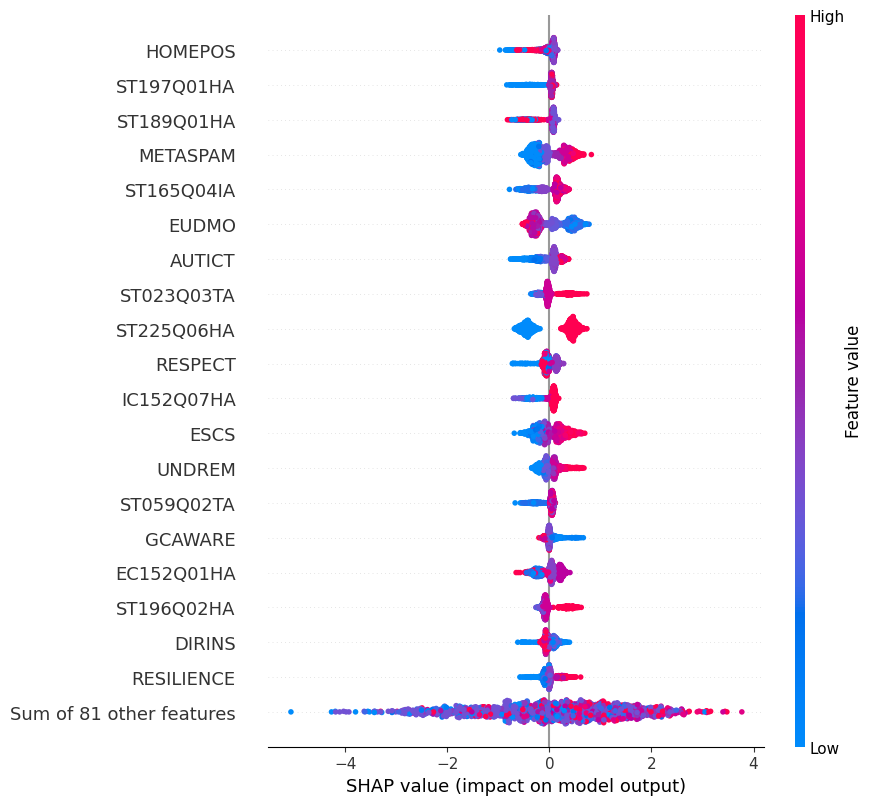

In [22]:
shap.plots.beeswarm(shap_values,max_display=20,order=shap_values.abs.max(0))